# Week VI: Image Segmentation

One of the most useful problems in computer vision is semantic segmentation. The main idea is to partition an image into separate meaningful groups. One could view segmentation as a pixel-wise classification problem.

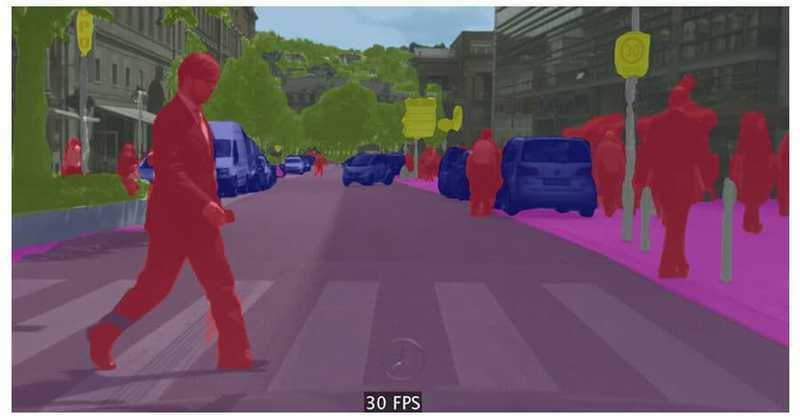

https://theaisummer.com/Semantic_Segmentation/

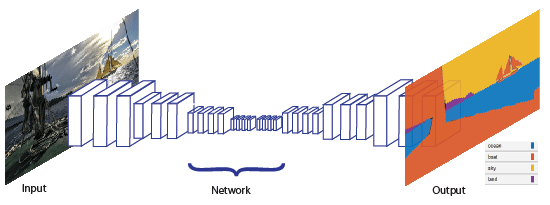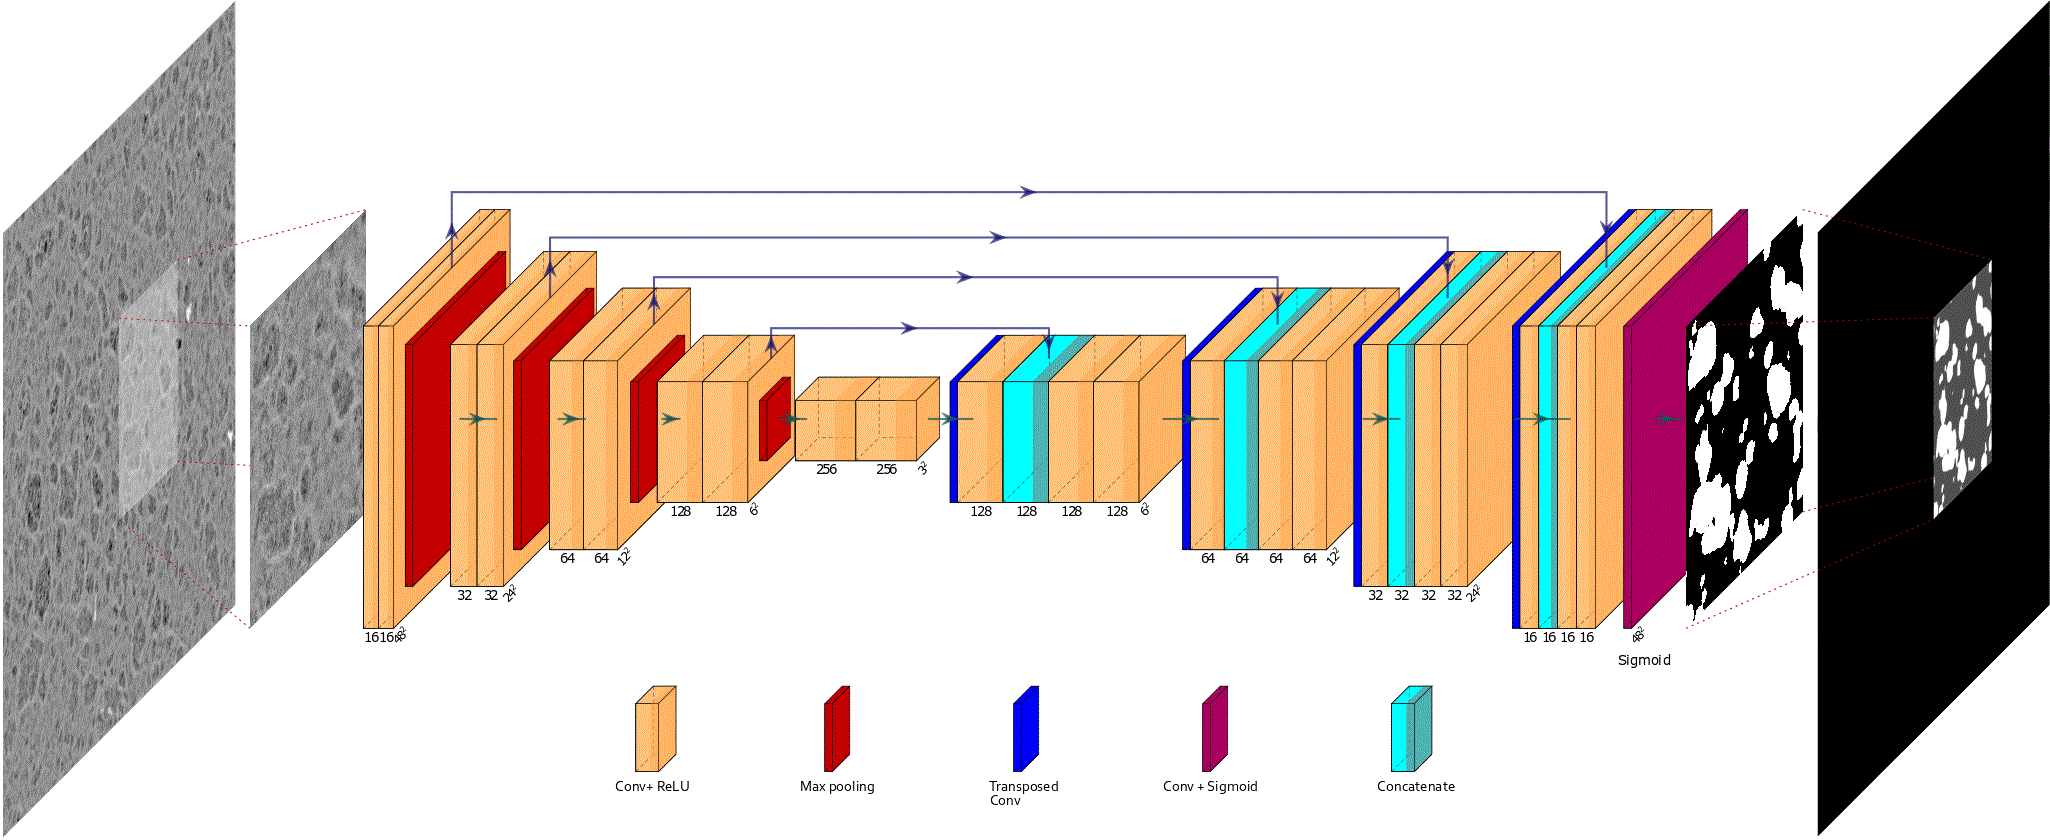

https://www.ifpenergiesnouvelles.com/brief/semantic-segmentation-through-deep-learning-materials-sciences

## Data handling

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image, display
from PIL import ImageOps

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from keras.backend import clear_session


Let's download the data:

In [ ]:
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  34.4M      0  0:00:21  0:00:21 --:--:-- 36.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  13.3M      0  0:00:01  0:00:01 --:--:-- 13.3M


The output is a compressed tar.gz file which we can unzip using the !tar -xf commandL

In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

These are our input and target directories:

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

Let's view one example:

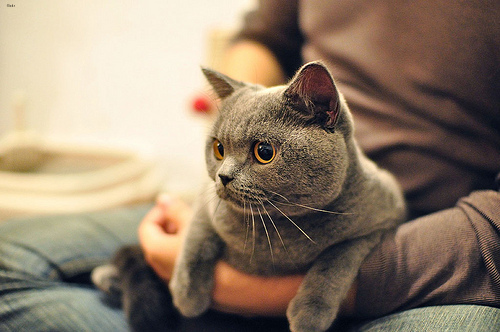

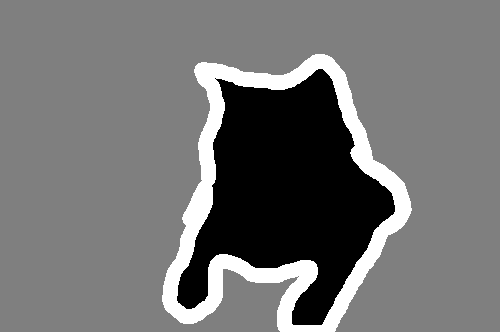

In [ ]:
image_path = "images/British_Shorthair_100.jpg" 
mask_path = "annotations/trimaps/British_Shorthair_100.png"
display(Image(filename=image_path))
img = ImageOps.autocontrast(load_img(mask_path))
display(img)

In [ ]:
input_dir = "images"
target_dir = "annotations/trimaps"

### Clean files

In [ ]:
input_files_to_delete = []
for fname in os.listdir(input_dir):
  if not fname.endswith(".jpg"):
    input_files_to_delete.append(fname)

In [ ]:
len(input_files_to_delete), input_files_to_delete[:5]

(3, ['Abyssinian_102.mat', 'Abyssinian_100.mat', 'Abyssinian_101.mat'])

In [ ]:
target_files_to_delete = []
for fname in os.listdir(input_dir):
  if not (fname.endswith(".png") and not fname.startswith(".")):
    target_files_to_delete.append(fname)

In [ ]:
len(target_files_to_delete), target_files_to_delete[:5]

(7393,
 ['Birman_117.jpg',
  'saint_bernard_74.jpg',
  'pug_181.jpg',
  'British_Shorthair_141.jpg',
  'Maine_Coon_137.jpg'])

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [ ]:
num_samples = len(input_img_paths)
num_samples

7390

In [ ]:
len(target_img_paths)

7390

In [ ]:
if not os.path.exists('input_images'):
  os.mkdir('input_images')

if not os.path.exists('target_images'):
  os.mkdir('target_images')

In [ ]:
input_img_paths[0]

'images/Abyssinian_1.jpg'

In [ ]:
input_img_paths[0].split('/')

['images/Abyssinian_1.jpg']

In [ ]:
os.path.join('input_images', input_img_paths[0].split('/')[1])

'input_images/Abyssinian_1.jpg'

In [ ]:
for file_name in input_img_paths:
  shutil.copyfile(file_name, os.path.join('input_images', file_name.split('/')[1]))

In [ ]:
target_img_paths[0]

'annotations/trimaps/Abyssinian_1.png'

In [ ]:
target_img_paths[0].split('/')

['annotations/trimaps/Abyssinian_1.png']

In [ ]:
os.path.join('target_images', target_img_paths[0].split('/')[1], target_img_paths[0].split('/')[2])

'target_images/trimaps/Abyssinian_1.png'

In [ ]:
target_img_paths[0].split('/')[2]

'Abyssinian_1.png'

In [ ]:
for file_name in target_img_paths:
  if len(file_name.split('/')) == 3:
    shutil.copyfile(file_name, os.path.join('target_images', file_name.split('/')[1], file_name.split('/')[2]))

In [ ]:
target_img_paths[0]

'annotations/trimaps/Abyssinian_1.png'

### Tensorflow datasets

In [ ]:
img_size = (128, 128)
num_classes = 3
batch_size = None

In [ ]:
img_ds = tf.keras.utils.image_dataset_from_directory(
  'input_images',
  shuffle=False,
  labels=None,
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 7390 files belonging to 1 classes.


In [ ]:
d = img_ds.take(1)

In [ ]:
len(list(d))

1

In [ ]:
len(list(d)[0])

128

In [ ]:
list(d)[0][0].shape

TensorShape([128, 3])

In [ ]:
im = list(d)[0].numpy()

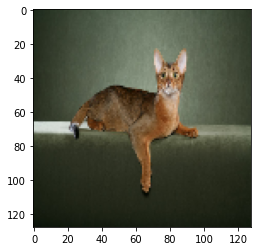

In [ ]:
plt.imshow(im / 255.)

In [ ]:
segmentation_mask_ds = tf.keras.utils.image_dataset_from_directory(
  "target_images",
  labels=None,
  shuffle=False,
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 7390 files belonging to 1 classes.


In [ ]:
s = segmentation_mask_ds.take(1)
s

<TakeDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
list(s)

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        ...,
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],
 
        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]], 

In [ ]:
im_s = list(s)[0].numpy()
im_s.shape

(128, 128, 3)

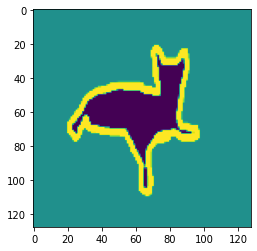

In [ ]:
plt.imshow(im_s[:, :, 0])

In [ ]:
(im_s[:, :, 2] == im_s[:, :, 2]).sum()

16384

In [ ]:
(im_s[:, :, 1] == im_s[:, :, 2]).sum()

16384

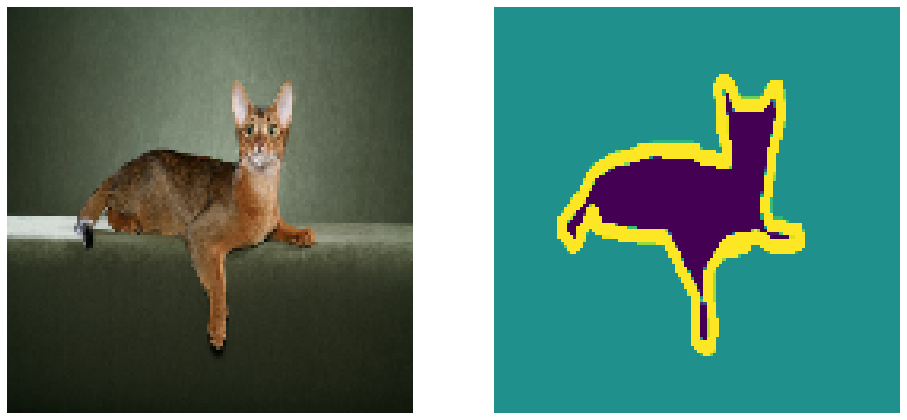

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].imshow(im / 255.)
axes[0].set_axis_off()

axes[1].imshow(im_s[:, :, 0])
axes[1].set_axis_off()

In [ ]:
# Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
segmentation_mask_ds = segmentation_mask_ds.map(lambda a: a[:, :, 0] - 1)

In [245]:
ds = tf.data.Dataset.zip((img_ds, segmentation_mask_ds))

In [ ]:
ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.float32, name=None))>

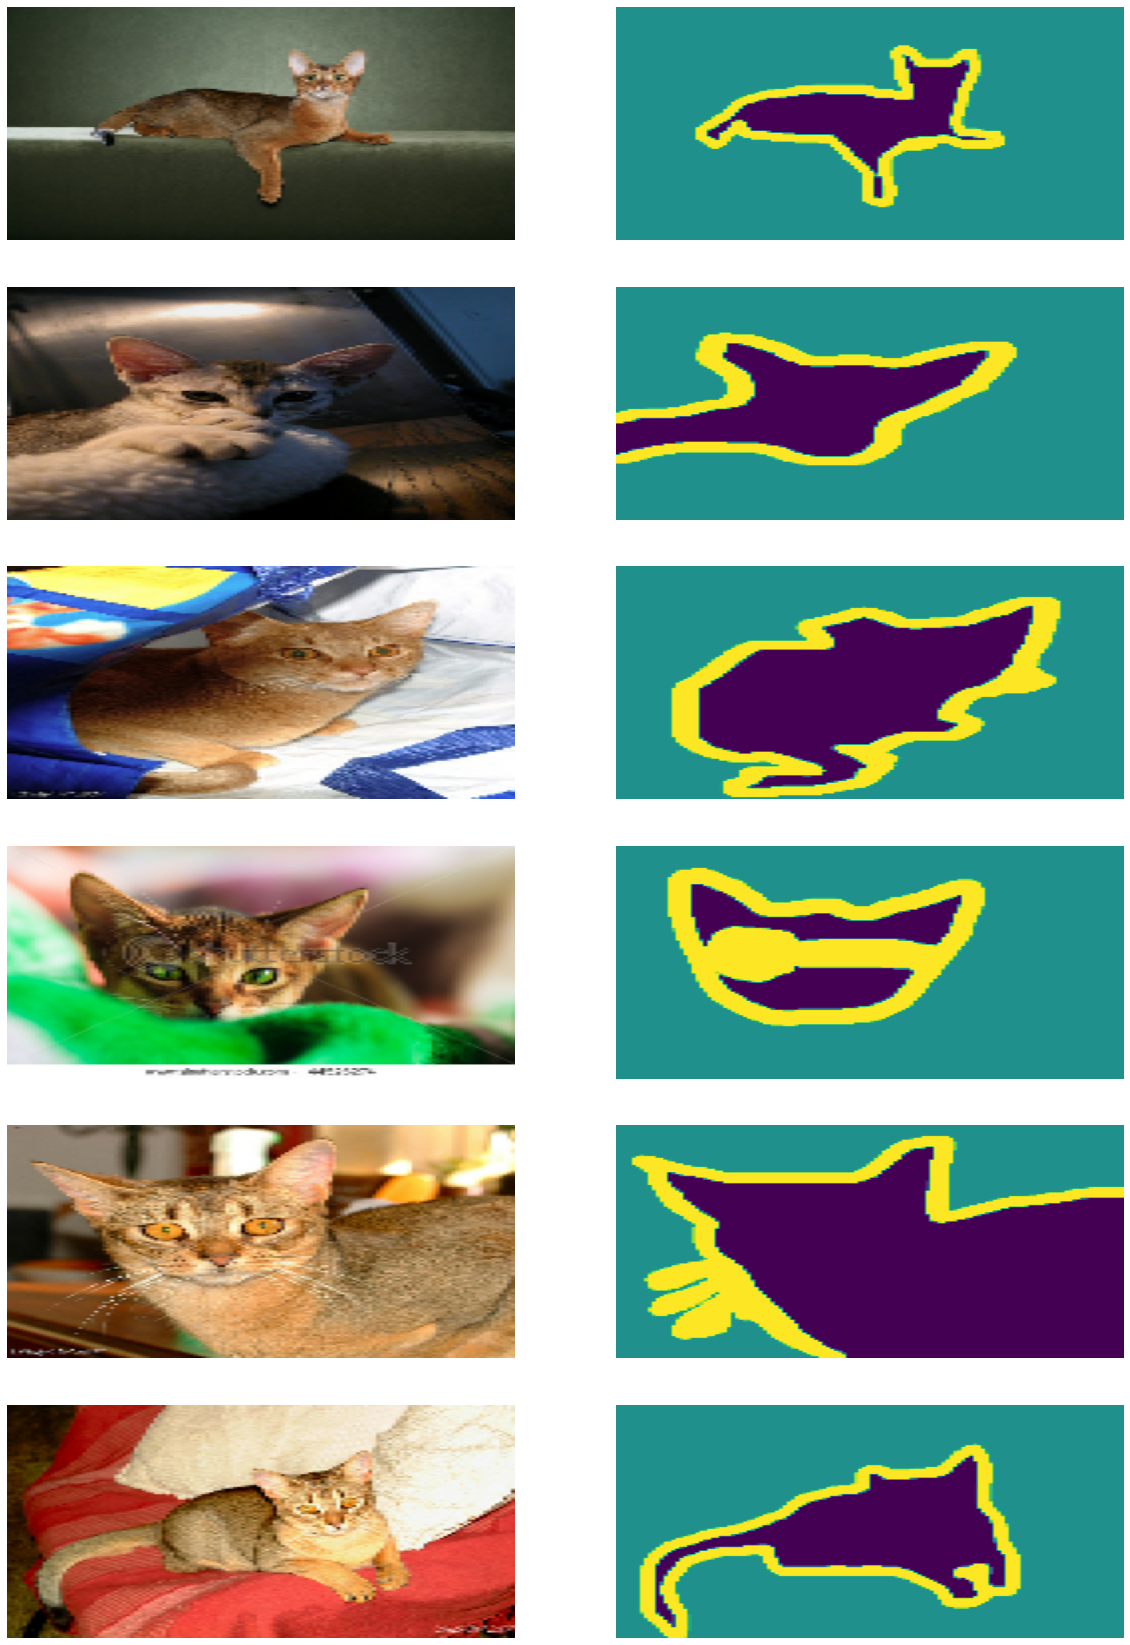

In [248]:
iter_ds = iter(ds)
fig, axes = plt.subplots(6, 2, figsize=(20, 30))
for i in range(6):
  image_batch, label_batch = next(iter_ds)
  axes[i, 0].imshow(image_batch.numpy().astype("uint8"), aspect="auto")
  axes[i, 0].set_axis_off()

  axes[i, 1].imshow(label_batch.numpy(), aspect="auto")
  axes[i, 1].set_axis_off()

plt.show()

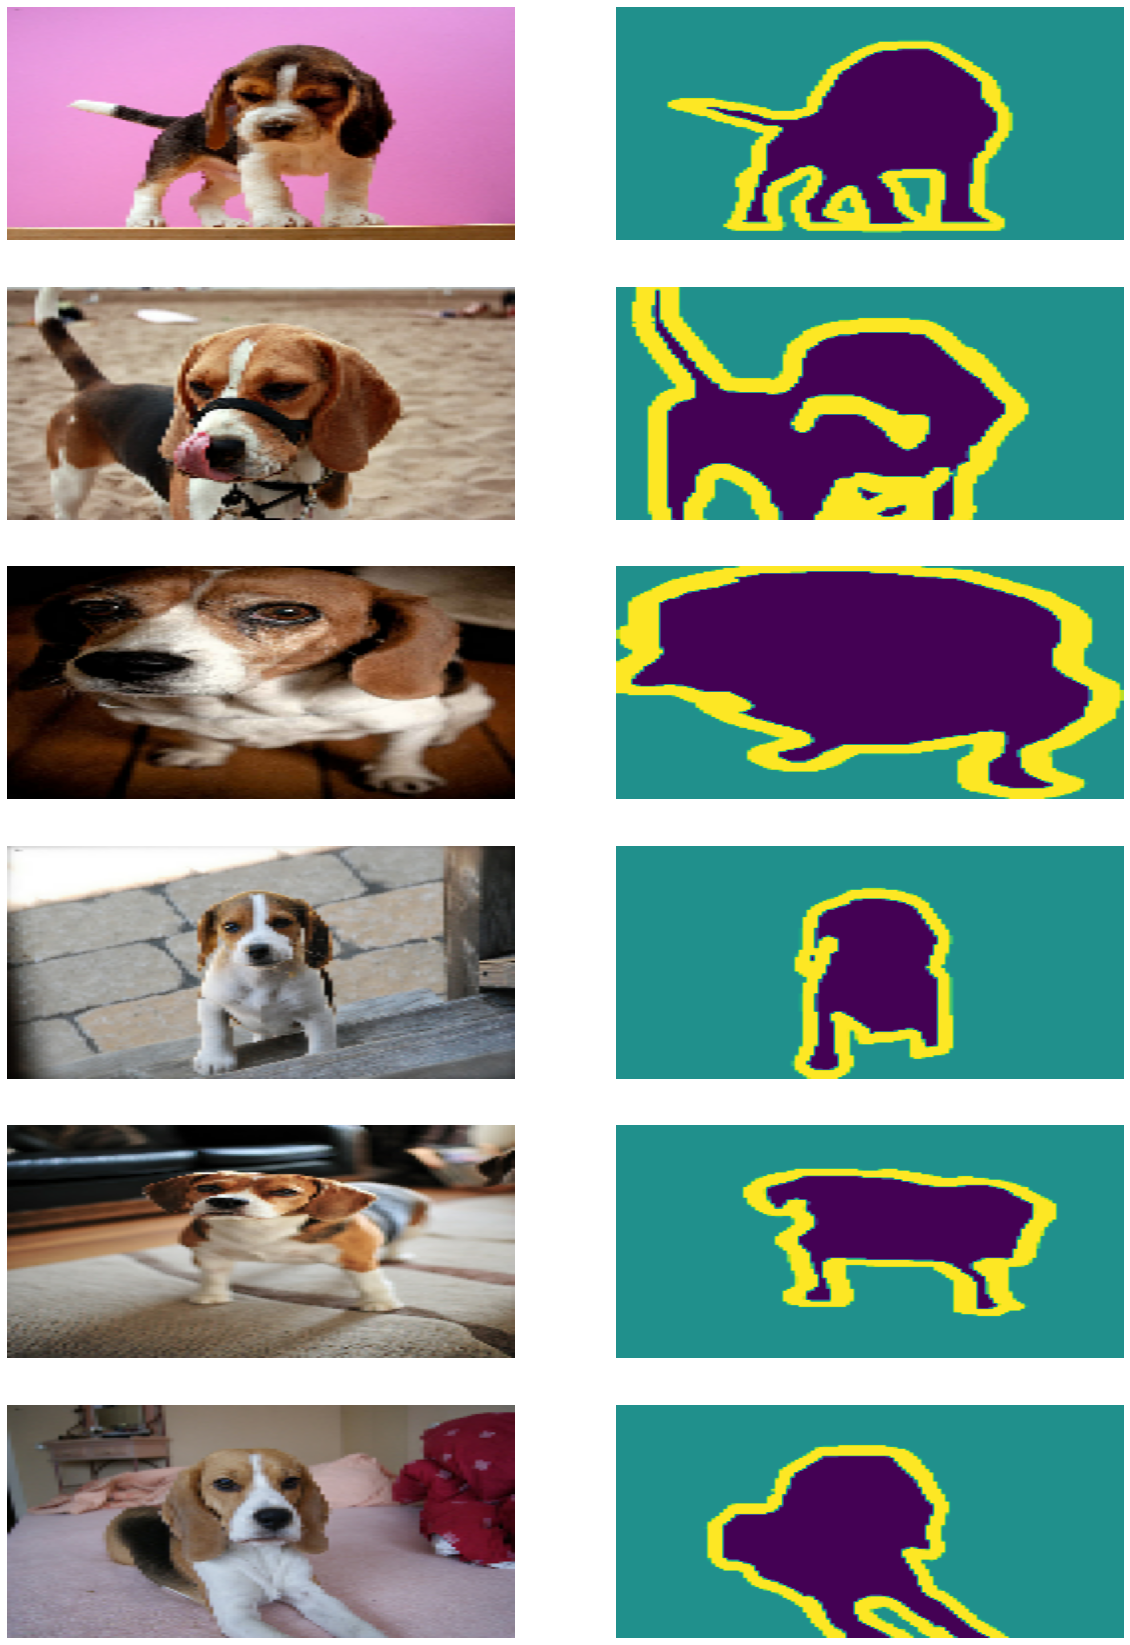

In [249]:
iter_ds = iter(ds.skip(3000))

fig, axes = plt.subplots(6, 2, figsize=(20, 30))
for i in range(6):
  image_batch, label_batch = next(iter_ds)
  axes[i, 0].imshow(image_batch.numpy().astype("uint8"), aspect="auto")
  axes[i, 0].set_axis_off()

  axes[i, 1].imshow(label_batch.numpy(), aspect="auto")
  axes[i, 1].set_axis_off()

plt.show()

## Train-test-split

In [ ]:
ds

<ZipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.float32, name=None))>

In [ ]:
len(ds)

7390

In [ ]:
ds = ds.shuffle(buffer_size=10000, reshuffle_each_iteration=False)

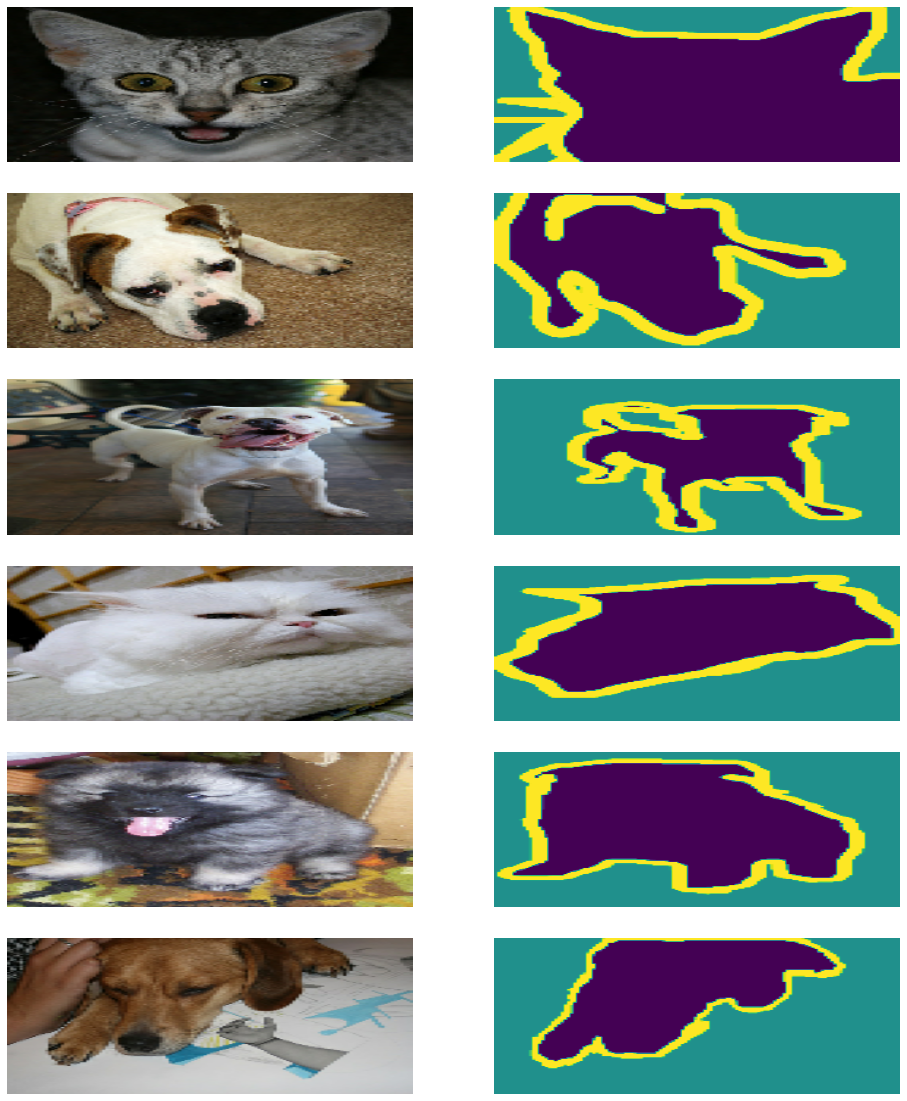

In [ ]:
iter_ds = iter(ds.take(6))
fig, axes = plt.subplots(6, 2, figsize=(16, 20))
for i in range(6):
  image_batch, label_batch = next(iter_ds)
  axes[i, 0].imshow(image_batch.numpy().astype("uint8"), aspect="auto")
  axes[i, 0].set_axis_off()

  axes[i, 1].imshow(label_batch.numpy(), aspect="auto")
  axes[i, 1].set_axis_off()

plt.show()

In [ ]:
ds = ds.batch(32)
ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None))>

In [ ]:
num_samples = len(ds)
num_samples

231

In [ ]:
train_end_index = int(num_samples * 0.8)
val_end_index = int(num_samples * 0.9)
test_end_index = num_samples
train_end_index, val_end_index, test_end_index

(184, 207, 231)

In [ ]:
train_ds = ds.take(train_end_index).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = ds.skip(train_end_index).take(val_end_index - train_end_index).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = ds.skip(val_end_index).take(test_end_index - val_end_index).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(184, 23, 24)

In [ ]:
# train_ds = train_ds.unbatch().batch(batch_size)
# val_ds = val_ds.unbatch().batch(batch_size)
# test_ds = test_ds.unbatch().batch(batch_size)

## Basic model

In [ ]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
if not os.path.exists("oxford_segmentation.h5"):
    model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, batch_size=32)

Epoch 1/15
184/184 [==============================] - 79s 249ms/step - loss: 0.8202 - val_loss: 2.7386
Epoch 2/15
184/184 [==============================] - 65s 249ms/step - loss: 0.5475 - val_loss: 2.7545
Epoch 3/15
184/184 [==============================] - 67s 251ms/step - loss: 0.4795 - val_loss: 1.0364
Epoch 4/15
184/184 [==============================] - 66s 252ms/step - loss: 0.4335 - val_loss: 0.5328
Epoch 5/15
184/184 [==============================] - 67s 257ms/step - loss: 0.3966 - val_loss: 0.5260
Epoch 6/15
184/184 [==============================] - 66s 253ms/step - loss: 0.3687 - val_loss: 0.5047
Epoch 7/15
184/184 [==============================] - 67s 249ms/step - loss: 0.3545 - val_loss: 0.5249
Epoch 8/15
184/184 [==============================] - 66s 251ms/step - loss: 0.3329 - val_loss: 0.5816
Epoch 9/15
184/184 [==============================] - 66s 250ms/step - loss: 0.3168 - val_loss: 0.5382
Epoch 10/15
184/184 [==============================] - 66s 253ms/step - l

## Transfer learning

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=img_size + (3,), include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
sub_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=[base_model.get_layer('conv3_block1_out').output])
sub_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
inputs = layers.Input(shape=img_size + (3,))
resnet_output = sub_model(inputs)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(resnet_output)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

resnet_model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
resnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 16, 16, 512)       612992    
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 256)       1179904   
                                                                 
 up_sampling2d_8 (UpSampling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       295040    
                                                                 
 up_sampling2d_9 (UpSampling  (None, 64, 64, 128)      0         
 2D)                                                       

In [ ]:
resnet_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation_resnet.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
if not os.path.exists("oxford_segmentation_resnet.h5"):
    resnet_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, batch_size=32)

Epoch 1/15
184/184 [==============================] - 63s 216ms/step - loss: 0.5550 - val_loss: 0.4697
Epoch 2/15
184/184 [==============================] - 60s 212ms/step - loss: 0.3546 - val_loss: 0.4491
Epoch 3/15
184/184 [==============================] - 58s 210ms/step - loss: 0.3186 - val_loss: 0.4701
Epoch 4/15
184/184 [==============================] - 58s 210ms/step - loss: 0.2961 - val_loss: 0.4803
Epoch 5/15
184/184 [==============================] - 58s 210ms/step - loss: 0.2797 - val_loss: 0.5740
Epoch 6/15
184/184 [==============================] - 58s 210ms/step - loss: 0.2678 - val_loss: 0.4950
Epoch 7/15
184/184 [==============================] - 60s 218ms/step - loss: 0.2581 - val_loss: 0.4364
Epoch 8/15
184/184 [==============================] - 58s 210ms/step - loss: 0.2487 - val_loss: 0.8511
Epoch 9/15
184/184 [==============================] - 58s 211ms/step - loss: 0.2396 - val_loss: 0.6414
Epoch 10/15
184/184 [==============================] - 58s 211ms/step - l

## Use the weights as-is

In [ ]:
sub_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=[base_model.get_layer('conv3_block1_out').output])
sub_model.trainable = False
sub_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
inputs = layers.Input(shape=img_size + (3,))
resnet_output = sub_model(inputs)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(resnet_output)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

resnet_model2 = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
resnet_model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 16, 16, 512)       612992    
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 256)       1179904   
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 32, 32, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 128)       295040    
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 64, 64, 128)      0         
 g2D)                                                      

In [ ]:
resnet_model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation_resnet2.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
if not os.path.exists("oxford_segmentation_resnet2.h5"):
    resnet_model2.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, batch_size=32)

Epoch 1/15
184/184 [==============================] - 55s 180ms/step - loss: 0.4010 - val_loss: 0.3642
Epoch 2/15
184/184 [==============================] - 54s 186ms/step - loss: 0.2780 - val_loss: 0.3511
Epoch 3/15
184/184 [==============================] - 52s 178ms/step - loss: 0.2617 - val_loss: 0.3468
Epoch 4/15
184/184 [==============================] - 52s 179ms/step - loss: 0.2527 - val_loss: 0.3424
Epoch 5/15
184/184 [==============================] - 53s 178ms/step - loss: 0.2460 - val_loss: 0.3410
Epoch 6/15
184/184 [==============================] - 53s 184ms/step - loss: 0.2401 - val_loss: 0.3419
Epoch 7/15
184/184 [==============================] - 52s 178ms/step - loss: 0.2355 - val_loss: 0.3438
Epoch 8/15
184/184 [==============================] - 52s 178ms/step - loss: 0.2317 - val_loss: 0.3437
Epoch 9/15
184/184 [==============================] - 52s 176ms/step - loss: 0.2280 - val_loss: 0.3461
Epoch 10/15
184/184 [==============================] - 53s 178ms/step - l

## Data augmentation

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
augmented_train_ds = ds.map(Augment())

In [ ]:
inputs = layers.Input(shape=img_size + (3,))
resnet_output = sub_model(inputs)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(resnet_output)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

resnet_model2 = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
resnet_model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 16, 16, 512)       612992    
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 256)       1179904   
                                                                 
 up_sampling2d_14 (UpSamplin  (None, 32, 32, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       295040    
                                                                 
 up_sampling2d_15 (UpSamplin  (None, 64, 64, 128)      0         
 g2D)                                                      

In [ ]:
resnet_model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation_data_augmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
if not os.path.exists("oxford_segmentation_data_augmentation.h5"):
    resnet_model2.fit(augmented_train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, batch_size=32)

Epoch 1/15
231/231 [==============================] - 60s 166ms/step - loss: 0.3818 - val_loss: 0.3638
Epoch 2/15
231/231 [==============================] - 57s 161ms/step - loss: 0.2885 - val_loss: 0.3407
Epoch 3/15
231/231 [==============================] - 57s 160ms/step - loss: 0.2733 - val_loss: 0.3277
Epoch 4/15
231/231 [==============================] - 56s 156ms/step - loss: 0.2649 - val_loss: 0.3205
Epoch 5/15
231/231 [==============================] - 56s 157ms/step - loss: 0.2593 - val_loss: 0.3165
Epoch 6/15
231/231 [==============================] - 56s 156ms/step - loss: 0.2547 - val_loss: 0.3120
Epoch 7/15
231/231 [==============================] - 55s 156ms/step - loss: 0.2505 - val_loss: 0.3092
Epoch 8/15
231/231 [==============================] - 56s 155ms/step - loss: 0.2471 - val_loss: 0.3050
Epoch 9/15
231/231 [==============================] - 56s 160ms/step - loss: 0.2447 - val_loss: 0.3073
Epoch 10/15
231/231 [==============================] - 55s 154ms/step - l

## VGG19

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=img_size + (3,), include_top=False)
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
sub_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=[base_model.get_layer('block4_conv4').output])
sub_model.trainable = False
sub_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
inputs = layers.Input(shape=img_size + (3,))
vgg_output = sub_model(inputs)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(vgg_output)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

vgg_model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
vgg_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_8 (Functional)        (None, 16, 16, 512)       10585152  
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 256)       1179904   
                                                                 
 up_sampling2d_20 (UpSamplin  (None, 32, 32, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 128)       295040    
                                                                 
 up_sampling2d_21 (UpSamplin  (None, 64, 64, 128)      0         
 g2D)                                                      

In [ ]:
vgg_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation_vgg.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
if not os.path.exists("oxford_segmentation_vgg.h5"):
    vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, batch_size=32)

Epoch 1/15
184/184 [==============================] - 64s 240ms/step - loss: 6.0980 - val_loss: 0.4943
Epoch 2/15
184/184 [==============================] - 70s 278ms/step - loss: 0.4541 - val_loss: 0.4257
Epoch 3/15
184/184 [==============================] - 76s 265ms/step - loss: 0.4038 - val_loss: 0.3913
Epoch 4/15
184/184 [==============================] - 85s 285ms/step - loss: 0.3745 - val_loss: 0.3743
Epoch 5/15
184/184 [==============================] - 79s 266ms/step - loss: 0.3560 - val_loss: 0.3634
Epoch 6/15
184/184 [==============================] - 70s 241ms/step - loss: 0.3424 - val_loss: 0.3551
Epoch 7/15
184/184 [==============================] - 65s 246ms/step - loss: 0.3321 - val_loss: 0.3490
Epoch 8/15
184/184 [==============================] - 64s 243ms/step - loss: 0.3236 - val_loss: 0.3435
Epoch 9/15
184/184 [==============================] - 66s 242ms/step - loss: 0.3162 - val_loss: 0.3381
Epoch 10/15
184/184 [==============================] - 70s 275ms/step - l

## Pix2Pix U-Net

Tensorflow examples:

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_size + (3,), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers_ = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers_)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
inputs = tf.keras.layers.Input(shape=img_size + (3,))

x = inputs

# Downsampling through the model
skips = down_stack(x)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# This is the last layer of the model
last = tf.keras.layers.Conv2DTranspose(
    num_classes, 3, strides=2,
    padding='same', activation='softmax')  #64x64 -> 128x128

y = last(x)

unet_model = tf.keras.Model(inputs=inputs, outputs=y)

In [ ]:
unet_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_10 (Functional)          [(None, 64, 64, 96)  1841984     ['input_11[0][0]']               
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                         

In [127]:
unet_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation_unet.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
if not os.path.exists("oxford_segmentation_unet.h5"):
    unet_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/15
184/184 [==============================] - 88s 290ms/step - loss: 0.6702 - val_loss: 0.6915
Epoch 2/15
184/184 [==============================] - 69s 214ms/step - loss: 0.5852 - val_loss: 0.5883
Epoch 3/15
184/184 [==============================] - 54s 188ms/step - loss: 0.5626 - val_loss: 0.5703
Epoch 4/15
184/184 [==============================] - 52s 181ms/step - loss: 0.5479 - val_loss: 0.5707
Epoch 5/15
184/184 [==============================] - 54s 190ms/step - loss: 0.5366 - val_loss: 0.5531
Epoch 6/15
184/184 [==============================] - 59s 187ms/step - loss: 0.5271 - val_loss: 0.5541
Epoch 7/15
184/184 [==============================] - 58s 188ms/step - loss: 0.5184 - val_loss: 0.5443
Epoch 8/15
184/184 [==============================] - 61s 204ms/step - loss: 0.5103 - val_loss: 0.5435
Epoch 9/15
184/184 [==============================] - 55s 193ms/step - loss: 0.5027 - val_loss: 0.5494
Epoch 10/15
184/184 [==============================] - 53s 186ms/step - l

## Evaluation

In [128]:
if os.path.exists('/content/oxford_segmentation.h5'):
  model = tf.keras.models.load_model('/content/oxford_segmentation.h5')

In [129]:
if os.path.exists('/content/oxford_segmentation_resnet.h5'):
  resnet_model = tf.keras.models.load_model('/content/oxford_segmentation_resnet.h5')

In [130]:
if os.path.exists('/content/oxford_segmentation_resnet2.h5'):
  resnet_model2 = tf.keras.models.load_model('/content/oxford_segmentation_resnet2.h5')

In [131]:
if os.path.exists('/content/oxford_segmentation_data_augmentation.h5'):
  augmented_model = tf.keras.models.load_model('/content/oxford_segmentation_data_augmentation.h5')

In [132]:
if os.path.exists('/content/oxford_segmentation_unet.h5'):
  unet_model = tf.keras.models.load_model('/content/oxford_segmentation_unet.h5')

In [133]:
if os.path.exists('/content/oxford_segmentation_vgg.h5'):
  vgg_model = tf.keras.models.load_model('/content/oxford_segmentation_vgg.h5')

In [134]:
pred_model = model.predict(test_ds, verbose=1, batch_size=64)
pred_resnet_model = resnet_model.predict(test_ds, verbose=1, batch_size=64)
pred_resnet_model2 = resnet_model2.predict(test_ds, verbose=1, batch_size=64)
pred_augmented_model = augmented_model.predict(test_ds, verbose=1, batch_size=64)
pred_unet_model = unet_model.predict(test_ds, verbose=1, batch_size=64)
pred_vgg_model = vgg_model.predict(test_ds, verbose=1, batch_size=64)

24/24 [==============================] - 24s 145ms/step


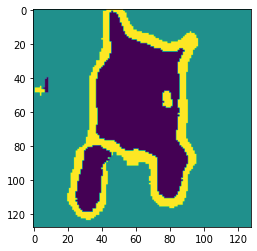

In [135]:
plt.imshow(tf.argmax(pred_resnet_model2[0], axis=-1).numpy())

In [136]:
pred_resnet_model2.shape

(766, 128, 128, 3)

In [137]:
test_labels = test_ds.map(lambda x, y: y)
test_labels

<MapDataset element_spec=TensorSpec(shape=(None, 128, 128), dtype=tf.float32, name=None)>

In [138]:
test_labels = list(test_labels) 

In [139]:
len(test_labels)

24

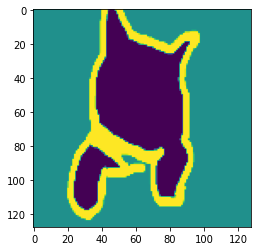

In [140]:
plt.imshow(test_labels[0][0, :, :])

In [141]:
test_labels = np.concatenate(test_labels, axis=0)
test_labels.shape

(766, 128, 128)

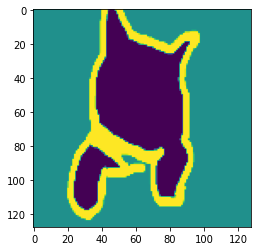

In [142]:
plt.imshow(test_labels[0, :, :])

In [143]:
pred_model_class = tf.argmax(pred_model, axis=-1).numpy()
pred_resnet_model_class = tf.argmax(pred_resnet_model, axis=-1).numpy()
pred_resnet_model_class2 = tf.argmax(pred_resnet_model2, axis=-1).numpy()
pred_augmented_model = tf.argmax(pred_augmented_model, axis=-1).numpy()
pred_unet_model_class = tf.argmax(pred_unet_model, axis=-1).numpy()
pred_vgg_model_class = tf.argmax(pred_vgg_model, axis=-1).numpy()

In [144]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
m.result().numpy()

0.33333334

In [145]:
def calculate_iou(y_true, y_pred):
  m = tf.keras.metrics.MeanIoU(num_classes=3)
  m.update_state(y_true, y_pred)
  return m.result().numpy()

In [146]:
iou_dict = {}

In [147]:
iou_dict['Original model'] = calculate_iou(test_labels, pred_model_class)
iou_dict['ResNet'] = calculate_iou(test_labels, pred_resnet_model_class)
iou_dict['ResNet2'] = calculate_iou(test_labels, pred_resnet_model_class2)
iou_dict['Augmented'] = calculate_iou(test_labels, pred_augmented_model)
iou_dict['VGG'] = calculate_iou(test_labels, pred_vgg_model_class)
iou_dict['Unet'] = calculate_iou(test_labels, pred_unet_model_class)

In [148]:
iou_dict

{'Original model': 0.57697374,
 'ResNet': 0.6196943,
 'ResNet2': 0.687279,
 'Augmented': 0.7209622,
 'VGG': 0.6740404,
 'Unet': 0.53600216}

In [164]:
num_samples_to_show = 1

In [150]:
test_samples_to_show = list(test_ds.take(num_samples_to_show))

In [175]:
def show_predictions(y_pred):
  fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(36, 12))
  if num_samples_to_show == 1:
    i = 0
    axes[0].imshow(test_samples_to_show[i][0][0, :, :, :] / 255., aspect="auto")
    axes[0].set_axis_off()
    axes[0].set_title('Original image')

    axes[1].imshow(test_samples_to_show[i][1][0, :, :], aspect="auto")
    axes[1].set_axis_off()
    axes[1].set_title('Ground truth')

    axes[2].imshow(y_pred[i, :, :], aspect="auto")
    axes[2].set_axis_off()
    axes[2].set_title('Predicted mask')
    return 1

  for i in range(num_samples_to_show):
    axes[i, 0].imshow(test_samples_to_show[i][0][0, :, :, :] / 255., aspect="auto")
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('Original image')

    axes[i, 1].imshow(test_samples_to_show[i][1][0, :, :], aspect="auto")
    axes[i, 1].set_axis_off()
    axes[i, 1].set_title('Ground truth')

    axes[i, 2].imshow(y_pred[i, :, :], aspect="auto")
    axes[i, 2].set_axis_off()
    axes[i, 2].set_title('Predicted mask')

1

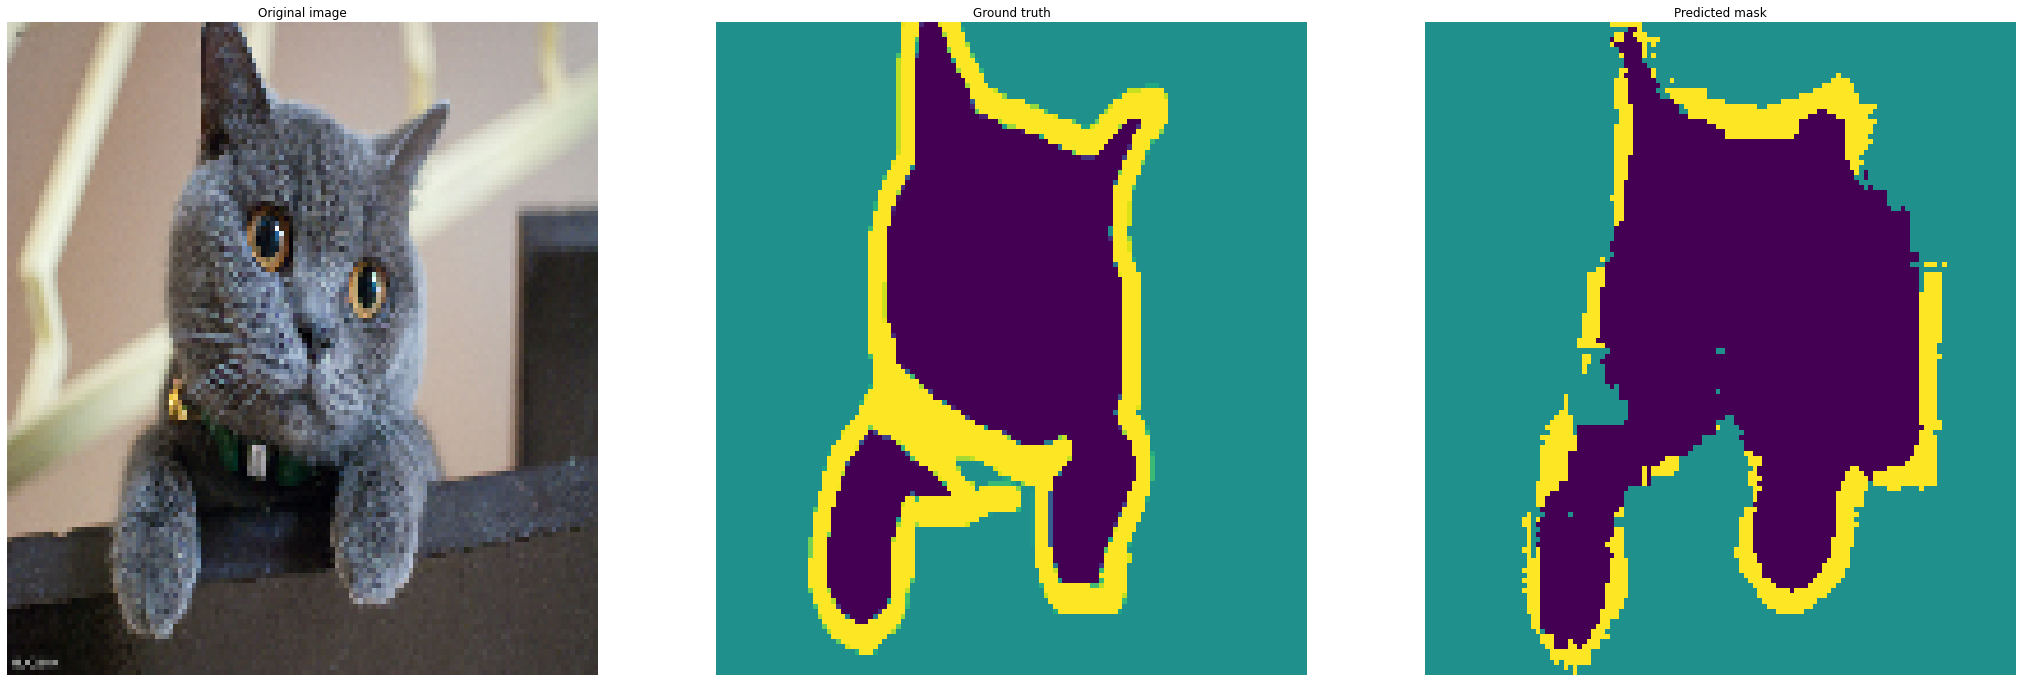

In [176]:
show_predictions(pred_model_class)

1

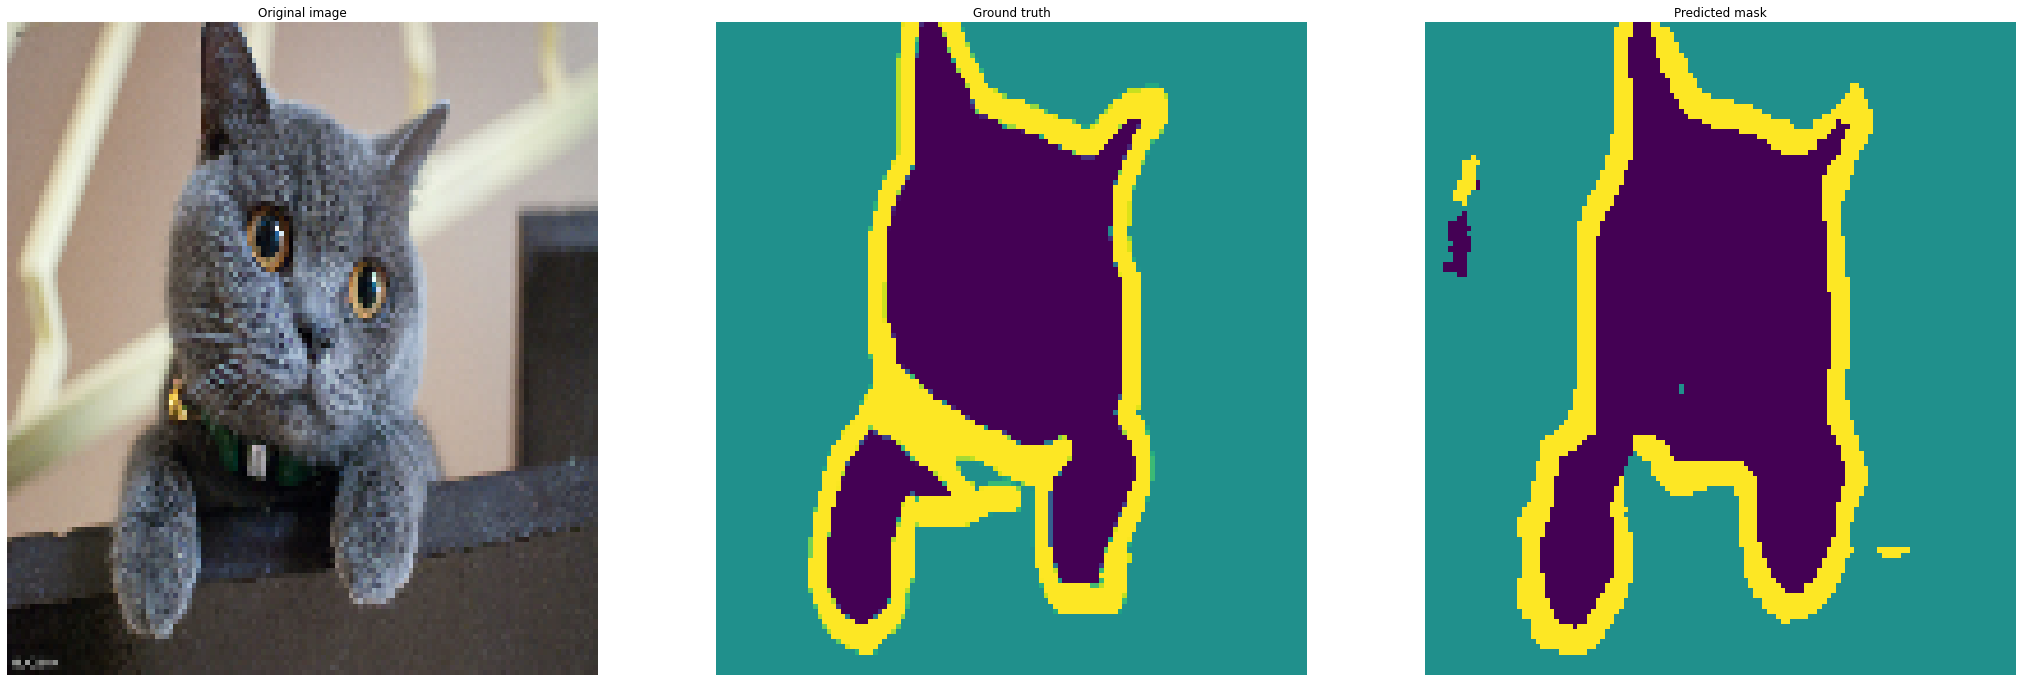

In [177]:
show_predictions(pred_resnet_model_class)

1

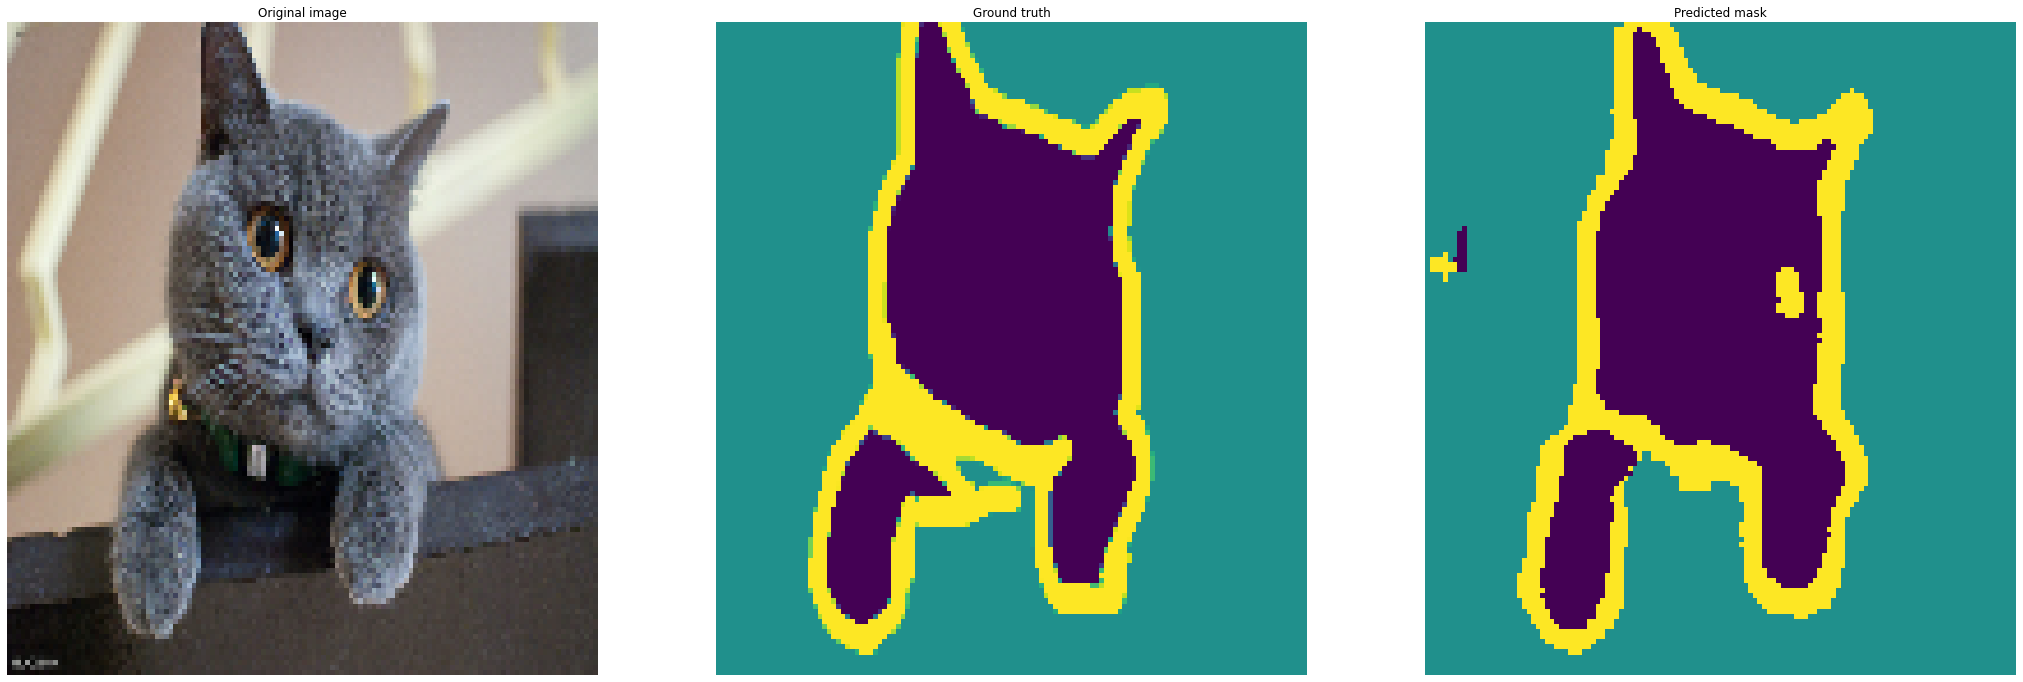

In [178]:
show_predictions(pred_resnet_model_class2)

1

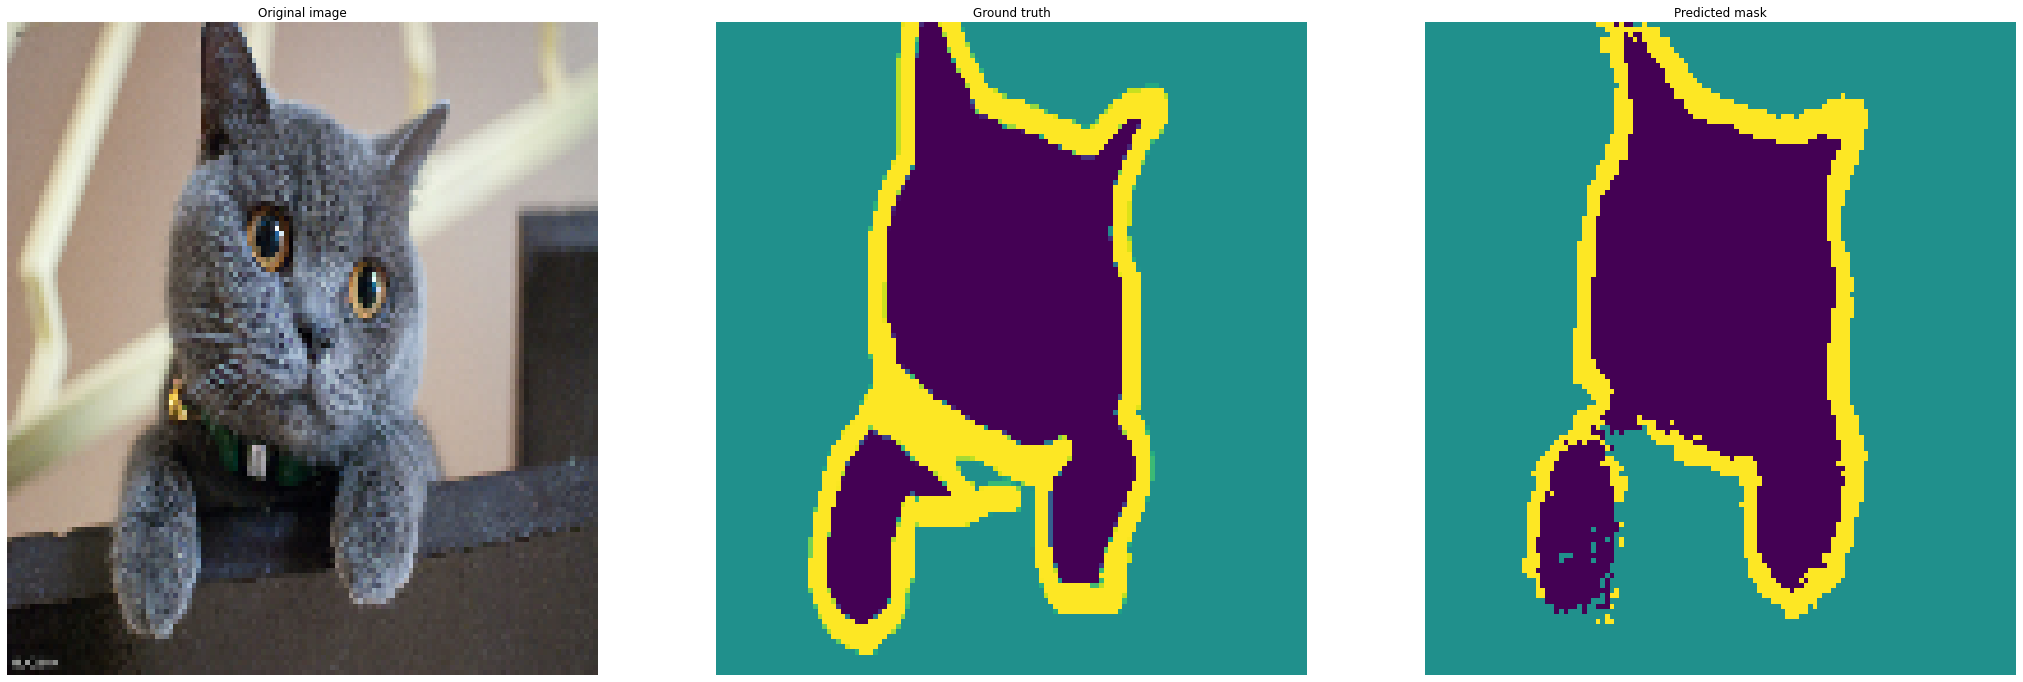

In [179]:
show_predictions(pred_vgg_model_class)

1

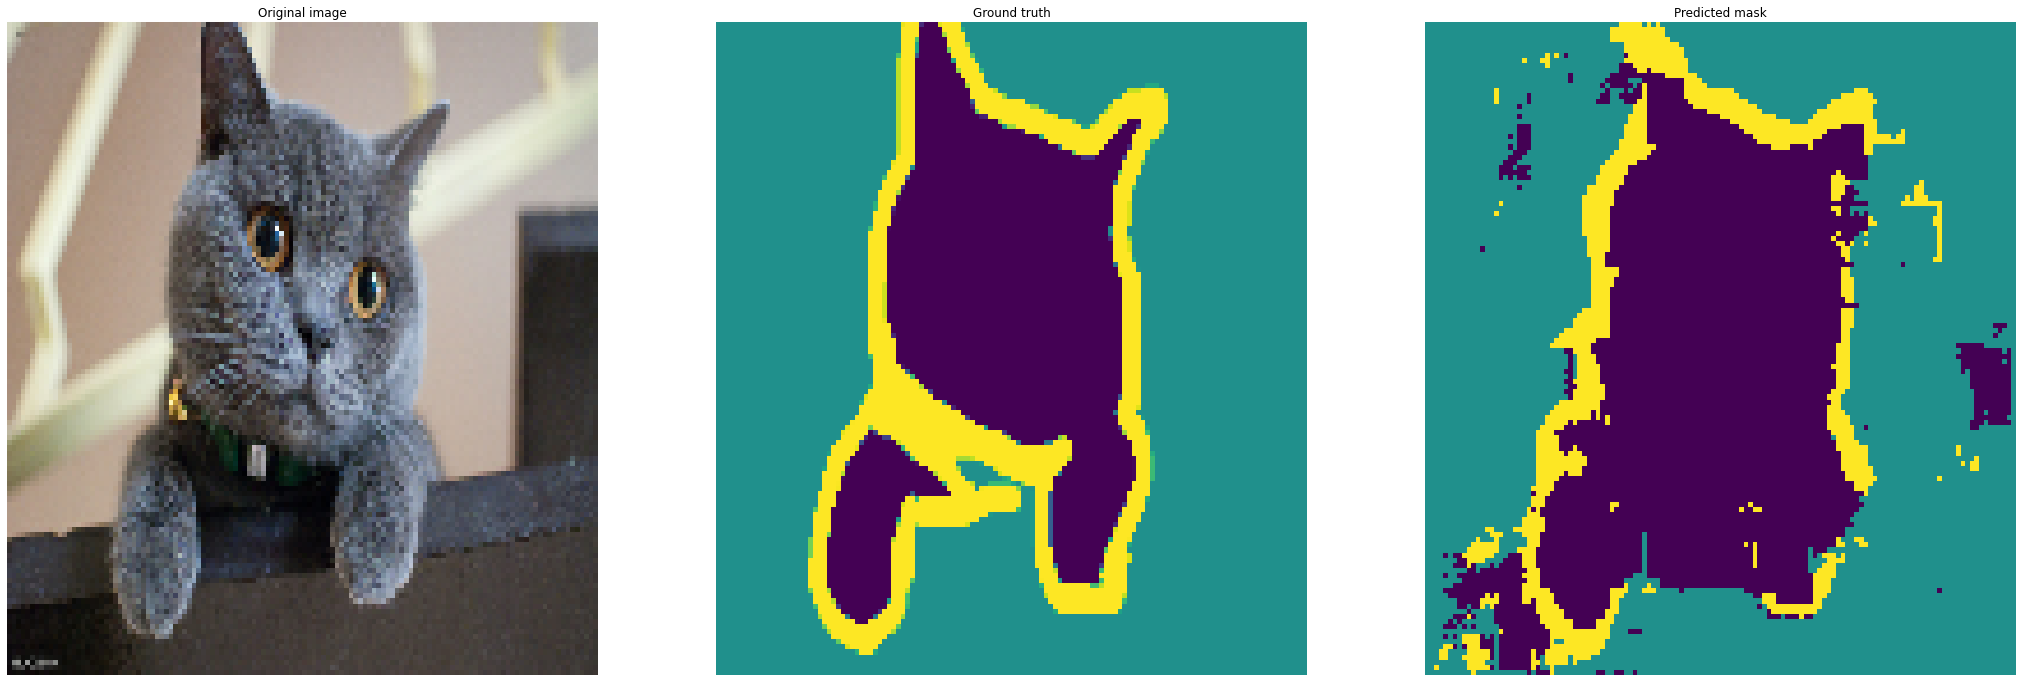

In [180]:
show_predictions(pred_unet_model_class)

1

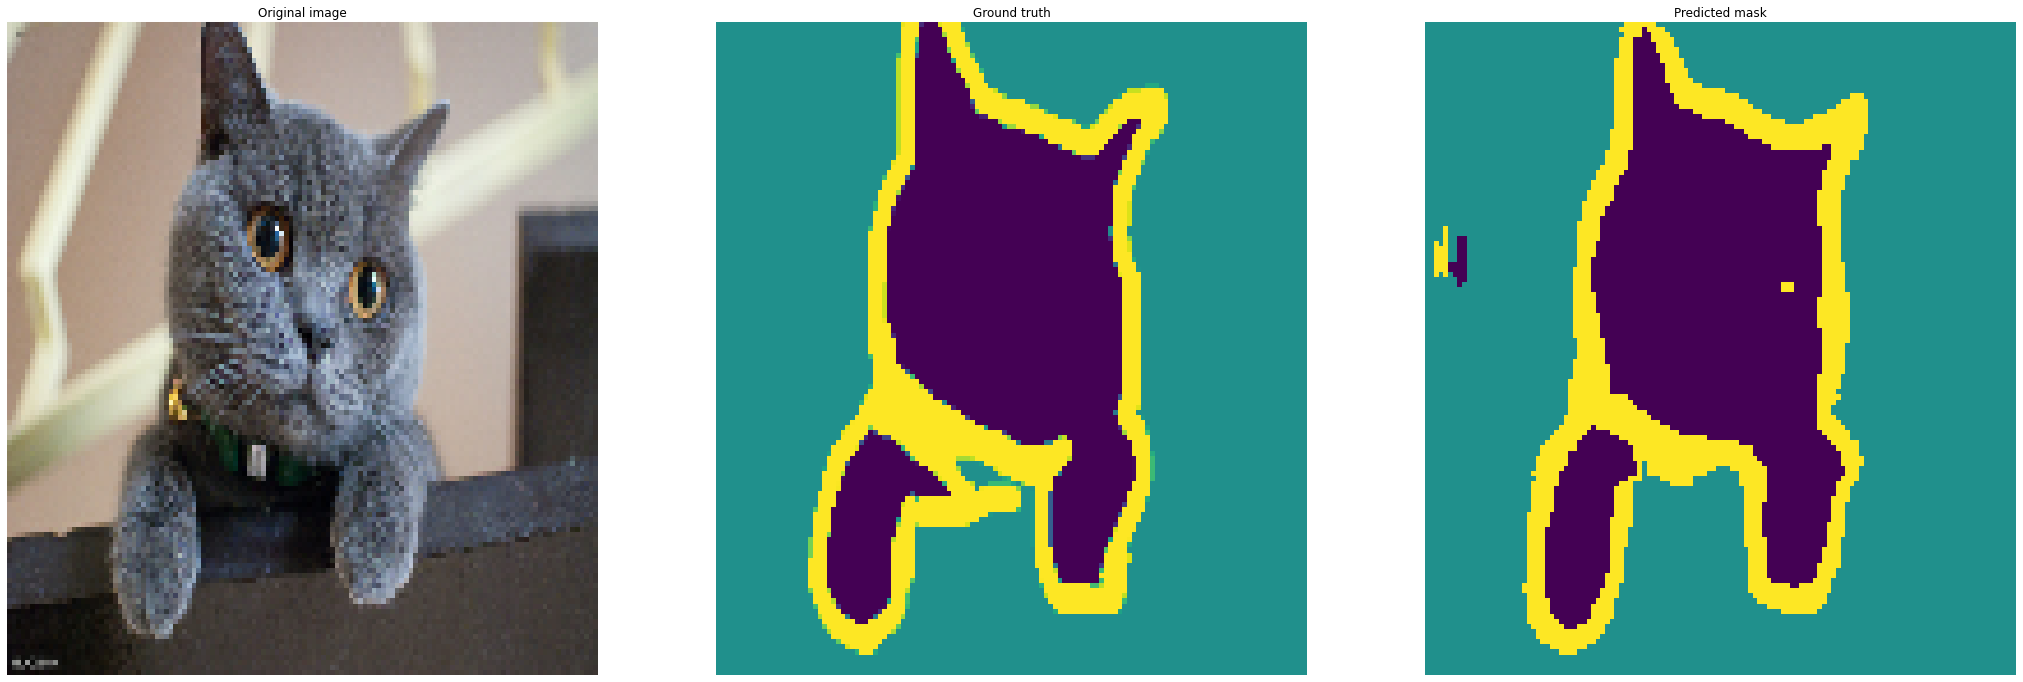

In [181]:
show_predictions(pred_augmented_model)